# Análise Exploratória Ideb (melhorar esse título)

Esse trabalho consiste em uma análise exploratória dos dados do Índice de Desenvolvimento da Educação Básica (Ideb) nos municípios do estado do Rio de Janeiro.

Utilizamos bases de dados retiradas do site [Base dos Dados](https://basedosdados.org/dataset/br-inep-ideb), com os dados do Ideb, e um arquivo GeoJSON retirado de [geodata-br](https://github.com/tbrugz/geodata-br), com os dados geográficos necessários dos municípios do Rio de Janeiro, para realizar as visualizações usando geopandas e outras ferramentas.

## Sumário

* [Importação das bibliotecas](#pct)
* [Preparação das bases](#bases)
    * [Dados geográficos](#1base)
    * [Dados IDEB](#2base)
* [Criação do banco de dados](#banco)
    * [Conexões entre as tabelas](#conn)
    * [Adição de metadados](#meta)
    * [Preparação para a análise](#pre_ana)
* [Análise Exploratória](#analise)

## Bibliotecas necessárias <a class="anchor" id="pct"></a>

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sqlalchemy import create_engine
from geoalchemy2 import Geometry
import sqlite3
import matplotlib
from shapely import wkt #converter de string para geometry
import mapclassify #para plotar os gráficos

## Preparação das as bases <a class="anchor" id="bases"></a>

### Dados geográficos <a class="anchor" id="1base"></a>

A primeira base consiste nos dados geográficos dos municípios do Rio de Janeiro que vamos utilizar para plotar os mapas.

Usamos o [DownGit](https://downgit.github.io/#/home) para fazer o download do `.json` do [ Repositório Telmo](https://github.com/tbrugz/geodata-br/blob/master/geojson/geojs-33-mun.json)

In [3]:
zipfile = "geojs-33-mun.json.zip"
rio_municipios = gpd.read_file(zipfile)
rio_municipios = rio_municipios.drop(columns = 'description') #A coluna description é igual à coluna name, então vamos retirá-la

print(type(rio_municipios))

rio_municipios.head()

<class 'geopandas.geodataframe.GeoDataFrame'>


,id,name,geometry
0,3300100,Angra dos Reis,"POLYGON ((-44.19557 -23.09831, -44.19445 -23.1..."
1,3300159,Aperibé,"POLYGON ((-42.11517 -21.60398, -42.11585 -21.6..."
2,3300209,Araruama,"POLYGON ((-42.18220 -22.55217, -42.13226 -22.6..."
3,3300225,Areal,"POLYGON ((-43.05873 -22.18937, -43.04773 -22.2..."
4,3300233,Armação dos Búzios,"POLYGON ((-41.93436 -22.76580, -41.91900 -22.7..."


### Dados IDEB <a class="anchor" id="2base"></a>

Já a segunda base reúne todos os dados sobre o Índice de Desenvolvimento da Educação Básica (Ideb). Vamos filtrá-la e utilizar apenas os dados referentes ao estado do Rio.

In [4]:
csvfile = "municipio.csv"
municipio = gpd.read_file(csvfile)
municipio.head()

,ano,sigla_uf,id_municipio,rede,ensino,anos_escolares,taxa_aprovacao,indicador_rendimento,nota_saeb_matematica,nota_saeb_lingua_portuguesa,nota_saeb_media_padronizada,ideb,projecao,geometry
0,2005,AC,1200013,estadual,fundamental,finais (6-9),90,0.89959502,223.3,209.69,3.88221,3.5,,None
1,2005,AC,1200013,estadual,fundamental,iniciais (1-5),80.4,0.76059997,167.8,154.39,3.972965,3,,None
2,2005,AC,1200013,municipal,fundamental,finais (6-9),,,,,,,,None
3,2005,AC,1200013,municipal,fundamental,iniciais (1-5),66.3,0.68155998,169.8,163,4.1680932,2.8,,None
4,2005,AC,1200013,publica,fundamental,finais (6-9),89,0.89366102,223.3,209.69,3.8821671,3.5,,None


Filtrando a base para selecionar apenas os dados desejados:

In [5]:
dados_rio = municipio[municipio['sigla_uf'] == "RJ"]
dados_rio = dados_rio.drop(columns = ['projecao','geometry']) #deleta a coluna projecao, pois há poucos dados sobre ela, e  a coluna
 #geometry pois essa base não possui esse tipo de dado
dados_rio.tail()

,ano,sigla_uf,id_municipio,rede,ensino,anos_escolares,taxa_aprovacao,indicador_rendimento,nota_saeb_matematica,nota_saeb_lingua_portuguesa,nota_saeb_media_padronizada,ideb
280698,2021,RJ,3306305,municipal,fundamental,iniciais (1-5),,,,,,
280699,2021,RJ,3306305,municipal,medio,todos (1-4),,,,,,
280700,2021,RJ,3306305,publica,fundamental,finais (6-9),,,,,,
280701,2021,RJ,3306305,publica,fundamental,iniciais (1-5),,,,,,
280702,2021,RJ,3306305,publica,medio,todos (1-4),,,,,,


Aproveitamos para deletar as linhas com dados faltantes e assim facilitar as nossas análises.

In [6]:
dados_rio['taxa_aprovacao'].replace('', np.nan, inplace=True)
dados_rio.dropna(subset=['taxa_aprovacao'], inplace=True)
dados_rio.index.names = ["id_dado"]
dados_rio

,ano,sigla_uf,id_municipio,rede,ensino,anos_escolares,taxa_aprovacao,indicador_rendimento,nota_saeb_matematica,nota_saeb_lingua_portuguesa,nota_saeb_media_padronizada,ideb
id_dado,,,,,,,,,,,,
18479,2005,RJ,3300100,estadual,fundamental,finais (6-9),69.6,0.69632202,241.39,230.69,4.5339708,3.2
18480,2005,RJ,3300100,estadual,fundamental,iniciais (1-5),81.5,0.81477797,179.8,173,4.5396662,3.7
18481,2005,RJ,3300100,municipal,fundamental,finais (6-9),69.2,0.70024502,247.19,236,4.7203331,3.3
18482,2005,RJ,3300100,municipal,fundamental,iniciais (1-5),73.9,0.73932397,189.39,182.19,4.8886571,3.6
18483,2005,RJ,3300100,publica,fundamental,finais (6-9),69.4,0.69687301,242.89,232,4.5811672,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...
240234,2019,RJ,3306305,municipal,fundamental,iniciais (1-5),91.8,0.91792399,242.47,230.5,6.782443,6.2
240235,2019,RJ,3306305,municipal,medio,todos (1-4),86.1,0.86114401,315.45,307.6,5.7250719,4.9
240236,2019,RJ,3306305,publica,fundamental,finais (6-9),88.8,0.888152,272.42,264.8,5.6205001,5


## Criação do banco de dados <a class="anchor" id="banco"></a>

Primeiro criamos a conexão e a tabela vazia 

In [7]:
conn = sqlite3.connect('ideb-database.db')
cur = conn.cursor()

In [8]:
cur.execute('''CREATE TABLE IF NOT EXISTS municipios_rio
             ('id_municipio' INT PRIMARY KEY NOT NULL,
             'name' text, 
             'geometry' text)''')
conn.commit()

Como não é possível passar o dataframe em Geopandas para o banco de dados, convertemos a tabela para Pandas e a coluna geometry para string

In [9]:
rio_municipios_pd = pd.DataFrame(rio_municipios)
rio_municipios_pd['geometry'] = rio_municipios_pd['geometry'].astype(str)

In [10]:
rio_municipios_pd.to_sql('municipios_rio', con=conn, if_exists='replace')
conn.commit()

Para checar que os dados foram adicionados na tabela, inicialmente vazia, fizemos uma query teste

In [11]:
cur.execute("SELECT name FROM municipios_rio")
print(cur.fetchmany(10))

[('Angra dos Reis',), ('Aperibé',), ('Araruama',), ('Areal',), ('Armação dos Búzios',), ('Arraial do Cabo',), ('Barra do Piraí',), ('Barra Mansa',), ('Belford Roxo',), ('Bom Jardim',)]


O mesmo procedimento é realizado para o dataframe `dados_rio`, criando a tabela vazia, convertendo para Pandas e depois dazendo uma query teste

In [12]:
cur.execute('''CREATE TABLE IF NOT EXISTS dados_ideb_rio
             ('id_dado' INT PRIMARY KEY NOT NULL,
             'ano' INT NOT NULL,
             'sigla_uf' text,
             'id_municipio' INT NOT NULL,
             'rede' TEXT ,
             'ensino' TEXT,
             'anos_escolares' TEXT,
             'taxa_aprovacao' REAL,
             'indicador_rendimento' REAL,
             'nota_saeb_matematica' REAL,
             'nota_saeb_lingua_portuguesa' REAL,
             'nota_saeb_media_padronizada' REAL,
             'ideb' REAL)''')
conn.commit()

In [13]:
dados_rio.to_sql('dados_ideb_rio', con=conn, if_exists='replace')
conn.commit()

In [14]:
cur.execute("SELECT id_dado FROM dados_ideb_rio")
print(cur.fetchmany(10))

[(18479,), (18480,), (18481,), (18482,), (18483,), (18484,), (18485,), (18488,), (18489,), (18490,)]


### Conexões entre as tabelas <a class="anchor" id="conn"></a>

Cria uma tabela que relaciona as duas outras

In [15]:
cur.execute('''CREATE TABLE IF NOT EXISTS rel_municipios
             ('id_rel' INTEGER PRIMARY KEY AUTOINCREMENT,
              'id_dado' INT,
              'id_municipio' INT,
               FOREIGN KEY (id_dado)
                    REFERENCES dados_ideb_rio (id_dado)
               FOREIGN KEY (id_municipio)
                    REFERENCES municipios_rio (id_municipio)
             )''')
conn.commit()

Checa se todas as colunas da tabela foram adicionadas corretamente

In [16]:
cur.execute('''PRAGMA table_info(rel_municipios)''')
print(cur.fetchall())

[(0, 'id_rel', 'INTEGER', 0, None, 1), (1, 'id_dado', 'INT', 0, None, 0), (2, 'id_municipio', 'INT', 0, None, 0)]


In [17]:
cur.execute('''INSERT INTO rel_municipios (id_dado, id_municipio)
                SELECT id_dado,id_municipio
                FROM dados_ideb_rio;
            ''')
conn.commit()

In [18]:
cur.execute("SELECT * FROM rel_municipios")
print(cur.fetchmany(10))

[(1, 18479, 3300100), (2, 18480, 3300100), (3, 18481, 3300100), (4, 18482, 3300100), (5, 18483, 3300100), (6, 18484, 3300100), (7, 18485, 3300159), (8, 18488, 3300159), (9, 18489, 3300159), (10, 18490, 3300159)]


Por fim, checamos se todas as tabelas foram criadas no banco de dados

In [19]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('sqlite_sequence',), ('rel_municipios',), ('municipios_rio',), ('dados_ideb_rio',)]


### Adição de metadados <a class="anchor" id="meta"></a>

Primeiro, como os limites dos municípios podem ser alterados ao longo do tempo, vamos adicionar a última data de modificação na tabela `municipios_rio`

In [32]:
cur.execute('''ALTER TABLE municipios_rio
                ADD geom_last_update TEXT''')
conn.commit()

In [37]:
cur.execute('''UPDATE municipios_rio 
                SET geom_last_update = '2021-11-12' ''')
conn.commit()

Checando se os dados foram adicionados na tabela

In [39]:
cur.execute("SELECT geom_last_update FROM municipios_rio")
print(cur.fetchmany(10))

[('2021-11-12',), ('2021-11-12',), ('2021-11-12',), ('2021-11-12',), ('2021-11-12',), ('2021-11-12',), ('2021-11-12',), ('2021-11-12',), ('2021-11-12',), ('2021-11-12',)]


### Preparação para a análise <a class="anchor" id="pre_ana"></a>

In [20]:
dados = '''SELECT * FROM dados_ideb_rio d LEFT JOIN municipios_rio m ON d.id_municipio=m.id
'''

cur.execute(dados)
df = pd.read_sql_query(dados, conn)
df.head() 

,id_dado,ano,sigla_uf,id_municipio,rede,ensino,anos_escolares,taxa_aprovacao,indicador_rendimento,nota_saeb_matematica,nota_saeb_lingua_portuguesa,nota_saeb_media_padronizada,ideb,index,id,name,geometry
0,18479,2005,RJ,3300100,estadual,fundamental,finais (6-9),69.6,0.69632202,241.39,230.69,4.5339708,3.2,0,3300100,Angra dos Reis,"POLYGON ((-44.1955721491 -23.0983083542, -44.1..."
1,18480,2005,RJ,3300100,estadual,fundamental,iniciais (1-5),81.5,0.81477797,179.8,173,4.5396662,3.7,0,3300100,Angra dos Reis,"POLYGON ((-44.1955721491 -23.0983083542, -44.1..."
2,18481,2005,RJ,3300100,municipal,fundamental,finais (6-9),69.2,0.70024502,247.19,236,4.7203331,3.3,0,3300100,Angra dos Reis,"POLYGON ((-44.1955721491 -23.0983083542, -44.1..."
3,18482,2005,RJ,3300100,municipal,fundamental,iniciais (1-5),73.9,0.73932397,189.39,182.19,4.8886571,3.6,0,3300100,Angra dos Reis,"POLYGON ((-44.1955721491 -23.0983083542, -44.1..."
4,18483,2005,RJ,3300100,publica,fundamental,finais (6-9),69.4,0.69687301,242.89,232,4.5811672,3.2,0,3300100,Angra dos Reis,"POLYGON ((-44.1955721491 -23.0983083542, -44.1..."


Retiramos as colunas 'id' e 'index', pois o *id* está duplicada e o *index* não será utilizado.

In [21]:
df = df.drop(columns = ['id','index']) 

In [22]:
df.dtypes

id_dado                         int64
ano                            object
sigla_uf                       object
id_municipio                   object
rede                           object
ensino                         object
anos_escolares                 object
taxa_aprovacao                 object
indicador_rendimento           object
nota_saeb_matematica           object
nota_saeb_lingua_portuguesa    object
nota_saeb_media_padronizada    object
ideb                           object
name                           object
geometry                       object
dtype: object

Agora, para conseguirmos plotar mapas, transformamos nossa base em uma *GeoDataFrame*:

In [23]:
df = gpd.GeoDataFrame(df)

In [24]:
df.dtypes # verifica o tipo de dado de cada coluna

id_dado                         int64
ano                            object
sigla_uf                       object
id_municipio                   object
rede                           object
ensino                         object
anos_escolares                 object
taxa_aprovacao                 object
indicador_rendimento           object
nota_saeb_matematica           object
nota_saeb_lingua_portuguesa    object
nota_saeb_media_padronizada    object
ideb                           object
name                           object
geometry                       object
dtype: object

É possível observar que os dados da coluna geometria não são do tipo *geometry*, por isso vamos transformá-los. Além disso, também é necessário transformar os dados númericos em *float*, para que seja possível realizar as análises.

In [25]:
df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry']) 

Utilizamos pandas para transformar os dados numéricos:

In [26]:
df['taxa_aprovacao'] = pd.to_numeric(df['taxa_aprovacao'],errors='coerce')
df['indicador_rendimento'] = pd.to_numeric(df['indicador_rendimento'],errors='coerce')
df['nota_saeb_matematica'] = pd.to_numeric(df['nota_saeb_matematica'],errors='coerce')
df['nota_saeb_lingua_portuguesa'] = pd.to_numeric(df['nota_saeb_lingua_portuguesa'],errors='coerce')
df['nota_saeb_media_padronizada'] = pd.to_numeric(df['nota_saeb_media_padronizada'],errors='coerce')
df['ideb'] = pd.to_numeric(df['ideb'],errors='coerce')

In [27]:
df.dtypes

id_dado                           int64
ano                              object
sigla_uf                         object
id_municipio                     object
rede                             object
ensino                           object
anos_escolares                   object
taxa_aprovacao                  float64
indicador_rendimento            float64
nota_saeb_matematica            float64
nota_saeb_lingua_portuguesa     float64
nota_saeb_media_padronizada     float64
ideb                            float64
name                             object
geometry                       geometry
dtype: object

Finalmente, podemos começar a plotar os mapas e realizar as análises.

## Análise Exploratória <a class="anchor" id="analise"></a>

Estamos utilizando uma base rica em dados que nos permite uma grande variedade de tipos de análises. 

Vamos começar analisando quais municípios se destacam na educação básica, a partir do Ideb, das taxas de aprovação e dos índices de rendimento.

In [28]:
rank_ideb = df[['name', 'ideb', 'taxa_aprovacao', 'indicador_rendimento'
]].groupby(['name']).mean(['ideb', 'taxa_aprovacao', 'indicador_rendimento']).sort_values('ideb',ascending=False)
# ordenando acordo com o ideb de forma descrescente

rank_ideb

,ideb,taxa_aprovacao,indicador_rendimento
name,,,
Santo Antônio de Pádua,5.189362,91.170833,0.912127
Trajano de Moraes,5.092308,87.987805,0.882319
Sumidouro,5.022222,85.637838,0.858170
Itaocara,4.952083,85.008163,0.852302
Itaperuna,4.942000,89.847059,0.899680
...,...,...,...
São Gonçalo,3.604000,75.914000,0.761026
Duque de Caxias,3.603922,76.709804,0.772001
São João de Meriti,3.589796,77.993878,0.787206


Text(0.5, 1.0, 'Ideb por munícipio')

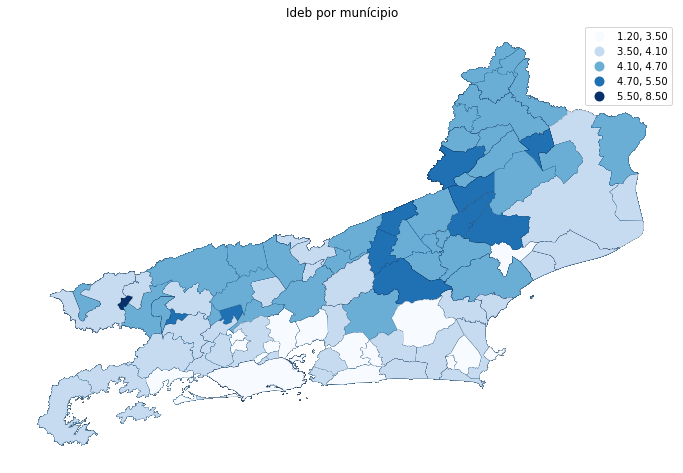

In [29]:
ideb_mun = df.plot(
    column="ideb",
    figsize=(12, 12), 
    edgecolor = 'black', 
    linewidth = 0.05,
    legend=True,
    cmap='Blues',
    scheme="natural_breaks")

ideb_mun.set_axis_off()
ideb_mun.set_title('Ideb por munícipio')

Text(0.5, 1.0, 'Taxa de aprovação por munícipio')

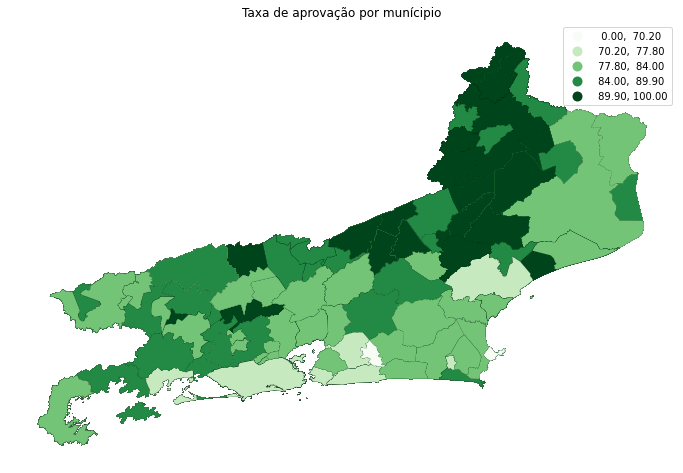

In [30]:
aprov_mun = df.plot(
    column="taxa_aprovacao",
    figsize=(12, 12), 
    edgecolor = 'black', 
    linewidth = 0.05,
    legend=True,
    cmap='Greens',
    scheme="natural_breaks")

aprov_mun.set_axis_off()
aprov_mun.set_title('Taxa de aprovação por munícipio')

Text(0.5, 1.0, 'Indicador de rendimento por munícipio')

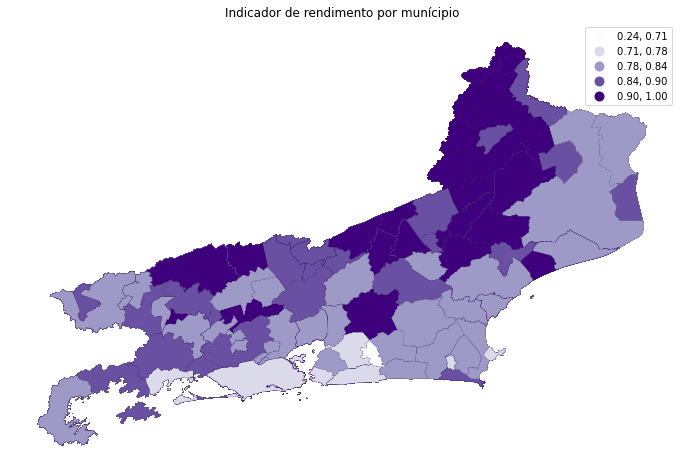

In [31]:
rendimento_mun = df.plot(
    column="indicador_rendimento",
    figsize=(12, 12), 
    edgecolor = 'black', 
    linewidth = 0.05,
    legend=True,
    cmap='Purples',
    scheme="natural_breaks")

rendimento_mun.set_axis_off()
rendimento_mun.set_title('Indicador de rendimento por munícipio')

Através desses três mapas é possível observar que os municípios que apresentam os maiores indicadores são, em geral, os mesmos e que eles sem concentram principalmente na região norte do estado.